# MovieLens with demographic data examples

Here we explore some data from the MovieLens database (https://grouplens.org/datasets/movielens/). We'll do some exploratory data analysis, visualization, and use some machine learning algorithms.

## Summary of process and tools used

1. Acquire data as csv files from the grouplens website
2. Run Python through Jupyter Notebook
3. Load csv file into pandas dataframe
4. Perform data analysis, visualization, and use machine learning algorithms
5. Control versions and save to Github using Git
6. Done on Mac OS X with Bash shell

## First look at the data

First we load packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
from scipy import stats
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf

Here we load the csv file as a pandas dataframe. We could also load it into a MySQL table and connect to a database, as is done in the mpg_project file. There are some other provided csv files, as explained in the README.txt file.

In [2]:
df_ratings = pd.read_table('ml-100k/u.data', names = ['userId', 'movieId', 'rating', 'timestamp']) #add header

Here we take a quick look at the header.

In [3]:
print(type(df_ratings))
print(list(df_ratings))

<class 'pandas.core.frame.DataFrame'>
['userId', 'movieId', 'rating', 'timestamp']


Let's take a look at the first five rows to get a feel for the data. The README.txt file included with the csv files explains more about the column fields. In short, userId and movieId ate unique tags, the ratings are from 1 to 5 stars in full star increments, and "Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970." 

In [4]:
df_ratings[:5]

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Here's the mean and mode of the ratings. They're a couple notches above the midpoint of the rating system which is $3$. It looks like the reviewers are generally positive!

In [5]:
print('%.2f' % df_ratings['rating'].mean())
print(df_ratings['rating'].mode()[0])

3.53
4


Here's a plot of the ratings.

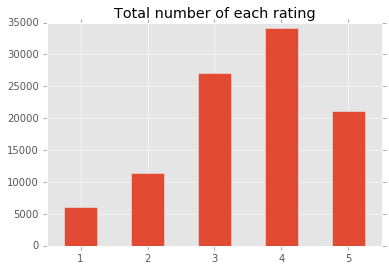

In [6]:
rating_counts = df_ratings['rating'].value_counts()
rating_counts = rating_counts.sort_index()

rating_counts.plot.bar()
plt.title('Total number of each rating')
plt.xticks(rotation=0)
plt.show()

Let's see how to convert a timestamp to a more recognizable format, and get a sense of the distribution of the reviews over time. The times are recored in Unix Epoch time.

In [7]:
#df_ratings[:1].timestamp[0] #the timestamp of the first entry
print(time.strftime('%Y-%m-%d', time.localtime(df_ratings[:1].timestamp[0]))) #time library
#time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(df_ratings[:1].timestamp[0])) #alternative

1997-12-04


The range of dates:
1997-09-20 to 1998-04-22

The five highest values:
1997-11-13    3550
1998-03-31    2217
1997-11-14    2197
1998-03-27    1999
1997-12-17    1801
Name: review_date, dtype: int64


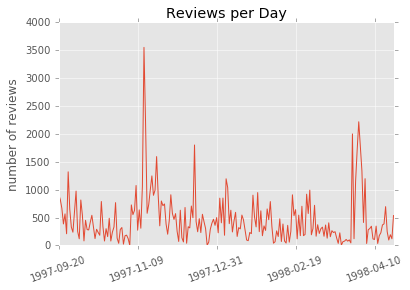

In [8]:
#Count timestamps for each day and plot a graph
df_ratings['review_date'] = pd.to_datetime(df_ratings['timestamp'], unit='s').dt.strftime('%Y-%m-%d') #using pandas
print('The range of dates:')
print df_ratings['review_date'].min() + ' to ' + df_ratings['review_date'].max() + '\n'
date_counts = df_ratings['review_date'].value_counts() #series type sorted by values, but we want it by index#Just use count?!
print('The five highest values:')
print(date_counts[:5]) # top 5 values
#type(date_counts) #series object
##http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html
date_counts = date_counts.sort_index() #; character suppresses output the proper idioimatic way?

date_counts.plot() 
plt.xticks(rotation=20)
plt.title('Reviews per Day')
plt.ylabel('number of reviews')
plt.show()

## Ratings trends from user demographic info

Let's look at some user demographics. We need to load the separate u.user file.

In [9]:
df_user = pd.read_table('ml-100k/u.user', sep='|', names = ['userId', 'age', 'gender', 'occupation', 'zip'])
print(type(df_user))
print(list(df_user))
df_user[:5]

<class 'pandas.core.frame.DataFrame'>
['userId', 'age', 'gender', 'occupation', 'zip']


,userId,age,gender,occupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


The ratings aren't independent since each user may have multiple reviews. Let's look at the average rating per user, and number of ratings per user, then merge the columns to the users dataframe.

In [10]:
avg_ratings = df_ratings.pivot_table(index='userId', values='rating', aggfunc='mean')
num_ratings = df_ratings.pivot_table(index='userId', values='rating', aggfunc='count')
df_user['avg_rating'] = avg_ratings.values
df_user['num_rating'] = num_ratings.values
df_user[:5]

,userId,age,gender,occupation,zip,avg_rating,num_rating
0,1,24,M,technician,85711,3.610294,272
1,2,53,F,other,94043,3.709677,62
2,3,23,M,writer,32067,2.796296,54
3,4,24,M,technician,43537,4.333333,24
4,5,33,F,other,15213,2.874286,175


Now let's run a regression to see the relation between average user rating and age.

In [11]:
regression = smf.ols(formula = 'avg_rating ~ age', data = df_user).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.177
Date:                Mon, 22 May 2017   Prob (F-statistic):            0.00434
Time:                        18:46:11   Log-Likelihood:                -570.44
No. Observations:                 943   AIC:                             1145.
Df Residuals:                     941   BIC:                             1155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4728      0.043     81.013      0.0

It looks like the age has a negligible influence on ratings, the ratings only go up by 0.0034 per year of age. Now let's check out the number of ratings and age.

In [12]:
regression2 = smf.ols(formula = 'num_rating ~ age', data = df_user).fit()
print(regression2.summary())

                            OLS Regression Results                            
Dep. Variable:             num_rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.271
Date:                Mon, 22 May 2017   Prob (F-statistic):            0.00412
Time:                        18:46:11   Log-Likelihood:                -5684.9
No. Observations:                 943   AIC:                         1.137e+04
Df Residuals:                     941   BIC:                         1.138e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.3570      9.717     13.621      0.0

This tells us that every 10 year age difference brings about 8 fewer ratings. The mean number of ratings is 106 as seen below.

In [13]:
print df_user.num_rating.mean()

106.044538706


The difference in the number of ratings based on gender is about 16, as we see below.

In [14]:
print df_user[df_user.gender == 'M'].num_rating.mean()
print df_user[df_user.gender == 'F'].num_rating.mean()

110.835820896
94.2857142857


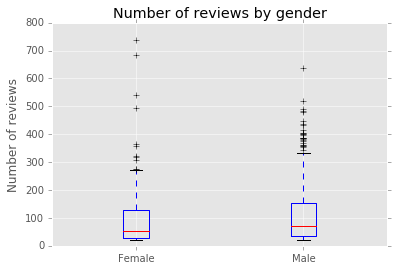

In [15]:
plt.boxplot([df_user[df_user.gender == 'F'].num_rating, 
             df_user[df_user.gender == 'M'].num_rating,
            ])
plt.title('Number of reviews by gender')
plt.xticks([1, 2], ['Female', 'Male'])
plt.ylabel('Number of reviews')
plt.show()

Now we'll merge the dataframes based on the userId column for convenience. This might not be a good idea if there's a larger dataset.

In [16]:
df = pd.merge(df_ratings, df_user, on='userId')
print(type(df))
print(list(df))
df[:5] #take a look

<class 'pandas.core.frame.DataFrame'>
['userId', 'movieId', 'rating', 'timestamp', 'review_date', 'age', 'gender', 'occupation', 'zip', 'avg_rating', 'num_rating']


,userId,movieId,rating,timestamp,review_date,age,gender,occupation,zip,avg_rating,num_rating
0,196,242,3,881250949,1997-12-04,49,M,writer,55105,3.615385,39
1,196,393,4,881251863,1997-12-04,49,M,writer,55105,3.615385,39
2,196,381,4,881251728,1997-12-04,49,M,writer,55105,3.615385,39
3,196,251,3,881251274,1997-12-04,49,M,writer,55105,3.615385,39
4,196,655,5,881251793,1997-12-04,49,M,writer,55105,3.615385,39


In [17]:
#regression3 = smf.ols(formula = 'avg_rating ~ age + gender + (1|userId)', data = df_user).fit()
#print(regression3.summary())